In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
index = 0
#neighbors_library = pickle.load(open("/develop/code/spie_meta_2023/src/meep_sim/neighbors_library_allrandom.pkl","rb"))
radii_list = np.round(np.random.uniform(0.075, 0.250, 9),3)

a = 0.680

x_list = [-a, 0, a, -a, 0, a, -a, 0, a]
y_list = [a, a, a, 0, 0, 0, -a, -a, -a]

In [3]:
resolution = 20
wavelength = 1.55
freq = 1 / wavelength

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

height_pillar = 1.020
#radius = 0.32
#radius = 0.1625
pml_thickness = 0.780
fusedSilica_thickness = 0.780
PDMS_thickness = 1.560

cell_x = a * 3
cell_y = a * 3
cell_z = pml_thickness + fusedSilica_thickness + height_pillar + PDMS_thickness + pml_thickness

top_pillar = pml_thickness + fusedSilica_thickness + (height_pillar - cell_z * 0.5)
bottom_pillar = top_pillar - height_pillar
lambda_over_two = top_pillar + wavelength / 2

center_fusedSilica = -0.5 * cell_z + 0.5 * (pml_thickness + fusedSilica_thickness)
center_PDMS = -0.5 * cell_z + pml_thickness + fusedSilica_thickness + 0.5 * (height_pillar + PDMS_thickness + pml_thickness)
center_pillar = -0.5 * cell_z + pml_thickness + fusedSilica_thickness + 0.5 * height_pillar

cell_size = mp.Vector3(cell_x, cell_y, cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

geometry = [ mp.Block(material = mp.Medium(index = n_fusedSilica),
                      size = mp.Vector3(mp.inf, mp.inf, pml_thickness + fusedSilica_thickness),
                      center = mp.Vector3(0,0, center_fusedSilica)),
             mp.Block(material=mp.Medium(index = n_PDMS),
                      size = mp.Vector3(mp.inf, mp.inf, height_pillar + PDMS_thickness + pml_thickness),
                      center = mp.Vector3(0, 0, center_PDMS)),
           ]


k_point = mp.Vector3(0, 0, 0)

source_center = -0.5 * cell_z + pml_thickness + 0.2 * fusedSilica_thickness
mon_posn = 0.5*cell_z - pml_thickness - 0.1 * PDMS_thickness + .1
print(mon_posn)
sources = [ mp.Source(mp.ContinuousSource(frequency = freq),
                      component = mp.Ey,
                      center = mp.Vector3(0, 0, source_center),
                      size = mp.Vector3(cell_x, cell_y, 0))
          ]
for i, neighbor in enumerate(radii_list):
    geometry.append(mp.Cylinder(material = mp.Medium(index = n_amorphousSi),
                       axis = mp.Vector3(0, 0, 1),
                       radius = neighbor,
                       height = height_pillar,
                       center = mp.Vector3(x_list[i], y_list[i], center_pillar)))
    print(f"appended geometry {i}: rad={neighbor}")

sim = mp.Simulation(cell_size = cell_size,
                   geometry = geometry,
                   sources = sources,
                   boundary_layers = pml_layers,
                   k_point = k_point,
                   resolution = resolution)

1.6240000000000006
appended geometry 0: rad=0.188
appended geometry 1: rad=0.1
appended geometry 2: rad=0.121
appended geometry 3: rad=0.09
appended geometry 4: rad=0.186
appended geometry 5: rad=0.083
appended geometry 6: rad=0.152
appended geometry 7: rad=0.167
appended geometry 8: rad=0.203


/develop/build/miniconda3/lib/python3.10/site-packages/meep/visualization.py:1402: UserWarning: Warning: The 'sim' argument in Animate2D is deprecated and has no effect. It will be removed in a future release.
  warnings.warn(


FloatProgress(value=100.0, description='0% done ', max=200.0, min=100.0)

     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.188, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.1, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0.68,0.68,-0.39)
          radius 0.121, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (-0.68,0,-0.39)
          radius 0.09, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.

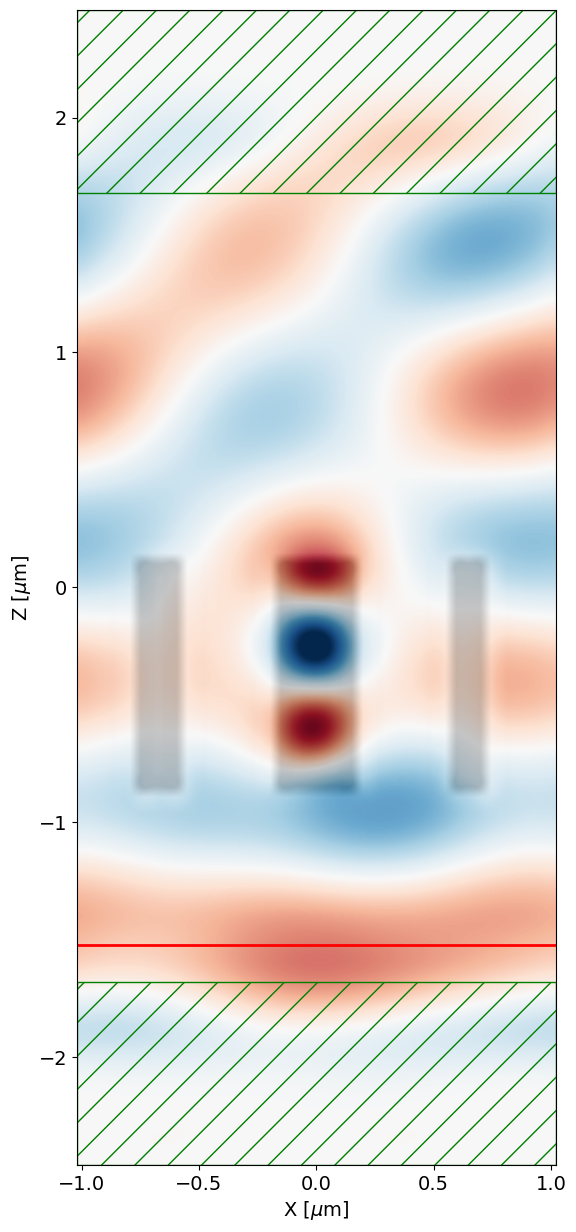

In [8]:
plot_plane = mp.Volume(center=mp.Vector3(0,0,0),
                            size=mp.Vector3(a*3,0,cell_z))

font = {'size': 14}

def mod_axes(ax):
    ax.set_xlabel('X [$\mu$m]', fontdict=font)
    ax.set_ylabel('Z [$\mu$m]', fontdict=font)
    ax.tick_params(axis='both', labelsize=14)
    return ax
plot_modifiers=[mod_axes]

f = plt.figure(dpi=100, figsize=(8,15))
Animate = mp.Animate2D(sim=sim, output_plane=plot_plane, fields=mp.Ey, f=f, realtime=False, normalize=True, plot_modifiers=plot_modifiers)
sim.run(mp.at_every(0.5, Animate), until=100)

In [9]:
filename = "efields_3x3.mp4"
fps = 20
Animate.to_mp4(fps, filename)

Generating MP4...


BrokenPipeError: [Errno 32] Broken pipe